# EIS Dataset RUL Analysis

This notebook analyzes the EIS (Electrochemical Impedance Spectroscopy) dataset for battery RUL (Remaining Useful Life) prediction.

In [1]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Layer,
    Conv1D,
    MaxPooling1D,
    Attention,
    MultiHeadAttention,
    LayerNormalization,
    Flatten,
    Dense,
    Dropout,
    LSTM,
    BatchNormalization,
    Add,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-09-18 00:39:15.154287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758155955.182371   48937 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758155955.190613   48937 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Global Constants
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
FEATURES = ['eis_imag']
FREQUENCIES_MAX = 20

In [3]:
# Set Base Path and Load Battery Data
eis_base_path = "/kaggle/input/eis-capacity/EIS data"
capacity_base_path = "/kaggle/input/eis-capacity/Capacity data"

temperatures = [25, 35, 45]
batteries_no = [
    [i for i in range(1, 9)],
    [1, 2],
    [1, 2],
]

class Battery:
    def __init__(self, name, df, temperature):
        self.name = name
        self.df = df
        self.temperature = temperature

    def __str__(self):
        return self.name

battery_data : list[Battery] = []
batteries : list[str] = []

In [4]:
def load_capacity_data(base_path, battery_name):
    fpath = os.path.join(base_path, f"Data_Capacity_{battery_name}" + '.txt')
    try:
        print(f"Loading capacity data for {battery_name}...")

        df = pd.read_csv(fpath, sep='\t')
        df.columns = df.columns.str.strip()
        df['cycle number'] = pd.to_numeric(df['cycle number'], errors='coerce')
        df['capacity'] = pd.to_numeric(df['Capacity/mA.h'], errors='coerce')
        df = df.dropna(subset=['cycle number', 'capacity'])

        # Transform cycle number and filter
        df['cycle number'] = df['cycle number'] * 2
        df = df[df['cycle number'] <= 500]

        # Take the last capacity of each cycle
        grouped = df.groupby('cycle number', as_index=False).last()

        first_cycle = grouped['cycle number'].min()
        init_cap = grouped[grouped['cycle number'] == first_cycle]['capacity'].max()
        # Calculate cycle at which capacity falls below 80% of initial capacity
        threshold = 0.8 * init_cap
        below_80 = grouped[grouped['capacity'] < threshold]

        if not below_80.empty:
            cycle_80 = below_80['cycle number'].iloc[0]
        else:
            cycle_80 = None

        grouped.rename(columns={'cycle number': 'cycle'}, inplace=True)

        return grouped, cycle_80

    except FileNotFoundError:
        print(f"{battery_name}: File not found.")

In [5]:
# Load data for each battery
battery_data.clear()
batteries.clear()
for temperature, batteries_number in zip(temperatures, batteries_no):
    for battery in batteries_number:
        # Read file
        battery_name = f"{temperature}C{battery:02d}"
        EIS_filename = f"EIS_state_V_{battery_name}.txt"

        batteries.append(battery_name)
        file_path = os.path.join(eis_base_path, EIS_filename)

        if temperature == 25:
            df = pd.read_csv(file_path, sep='\t') # Tab-delimited file
            df.columns = df.columns.str.strip() # Strip whitespace from column names

            # rename the columns
            df.rename(columns={'cycle number': 'cycle'}, inplace=True)
            df.rename(columns={'freq/Hz': 'frequency'}, inplace=True)
            df.rename(columns={'Re(Z)/Ohm': 'eis_real'}, inplace=True)
            df.rename(columns={'-Im(Z)/Ohm': 'eis_imag'}, inplace=True)

        else:
            df = pd.read_csv(file_path, sep='\t', header=None) # Tab-delimited file without header
            # Add header
            df.columns = ['time/s', 'cycle', 'frequency', 'eis_real', 'eis_imag', '|Z|/Ohm', 'Phase(Z)/deg']

        # Multiply cycle number by 2 because the measurements are taken in even-numbered cycles
        df['cycle'] = (df['cycle'] - 1) * 2

        # get capacity data and end of life (EOL)
        capacity_df, eol = load_capacity_data(capacity_base_path, battery_name)
        if eol is None:
            eol = df['cycle'].max()  # If no EOL found, use max cycle in EIS data

        print(f"Battery {battery_name}: EOL at cycle {eol}, max cycle in EIS data {df['cycle'].max()}")
        # Calculate Remaining Useful Life
        df['RUL'] = eol - df['cycle']
        # drop rows with negative or zero RUL
        df = df[df['RUL'] >= 0]
        df['temperature'] = temperature
        df['battery'] = battery_name
        # append capacity data
        df = pd.merge(df, capacity_df[['cycle', 'capacity']], on='cycle', how='left')

        battery_data.append(Battery(battery_name, df, temperature)) # Append battery data
        print(f"Loaded {EIS_filename}: {len(df):>5} rows")

print(f"\nLoaded {len(battery_data)} battery datasets")

Loading capacity data for 25C01...
Battery 25C01: EOL at cycle 234.0, max cycle in EIS data 520.0
Loaded EIS_state_V_25C01.txt:  7080 rows
Loading capacity data for 25C02...
Battery 25C02: EOL at cycle 12.0, max cycle in EIS data 498.0
Loaded EIS_state_V_25C02.txt:   420 rows
Loading capacity data for 25C03...
Battery 25C03: EOL at cycle 164.0, max cycle in EIS data 456.0
Loaded EIS_state_V_25C03.txt:  4980 rows
Loading capacity data for 25C04...
Battery 25C04: EOL at cycle 160.0, max cycle in EIS data 160.0
Loaded EIS_state_V_25C04.txt:  4860 rows
Loading capacity data for 25C05...
Battery 25C05: EOL at cycle 152.0, max cycle in EIS data 548.0
Loaded EIS_state_V_25C05.txt:  4620 rows
Loading capacity data for 25C06...
Battery 25C06: EOL at cycle 120.0, max cycle in EIS data 422.0
Loaded EIS_state_V_25C06.txt:  3660 rows
Loading capacity data for 25C07...
Battery 25C07: EOL at cycle 32.0, max cycle in EIS data 278.0
Loaded EIS_state_V_25C07.txt:  1020 rows
Loading capacity data for 25C

In [6]:
sample_battery = battery_data[0]
print(f"Sample data: {sample_battery}")
print(sample_battery.df.head())
print(sample_battery.df.info())

Sample data: 25C01
        time/s  cycle   frequency  eis_real  eis_imag  |Z|/Ohm  Phase(Z)/deg  \
0  12836.72676    0.0  20004.4530   0.38470  -0.03513  0.38630       5.21784   
1  12836.86976    0.0  15829.1260   0.39156  -0.01700  0.39193       2.48562   
2  12837.01176    0.0  12516.7030   0.39684   0.00009  0.39684      -0.01302   
3  12837.15376    0.0   9909.4424   0.40341   0.01405  0.40365      -1.99482   
4  12837.31776    0.0   7835.4800   0.40963   0.02612  0.41046      -3.64787   

     RUL  temperature battery   capacity  
0  234.0           25   25C01  37.202713  
1  234.0           25   25C01  37.202713  
2  234.0           25   25C01  37.202713  
3  234.0           25   25C01  37.202713  
4  234.0           25   25C01  37.202713  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time/s        7080 non-null   float64
 1   c

# Visualize Data

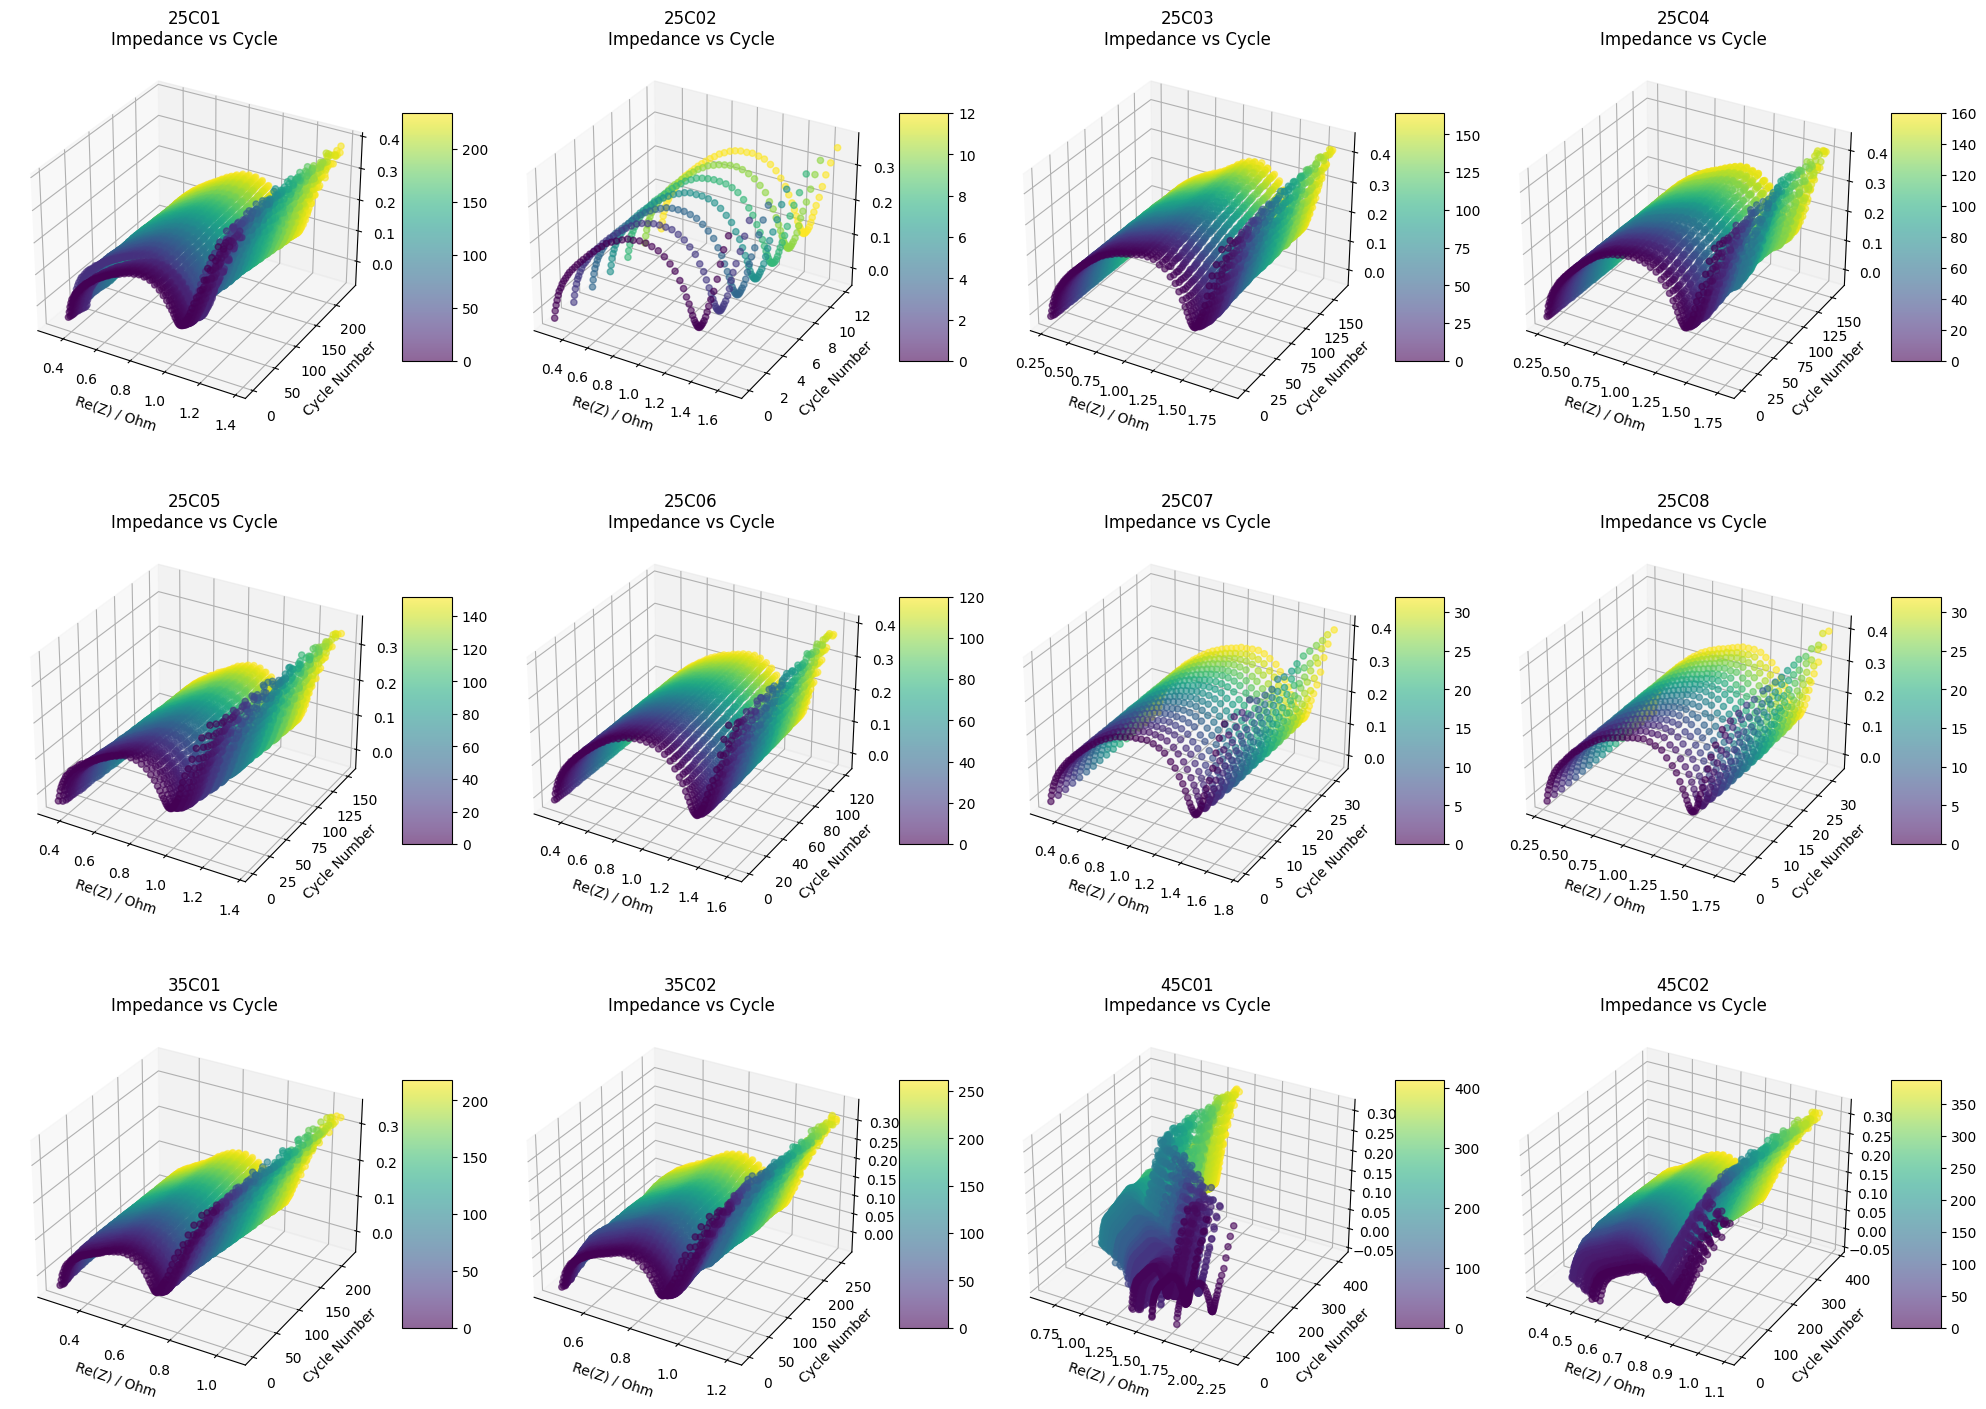

In [7]:
# Create 3D Plots for Each Battery
fig = plt.figure(figsize=(20, 15))

plot_num = 1
for battery in battery_data:
    ax = fig.add_subplot(3, 4, plot_num, projection='3d')
    
    # Create 3D scatter plot
    scatter = ax.scatter(battery.df['eis_real'], battery.df['cycle'], battery.df['eis_imag'],
                         c=battery.df['cycle'], cmap='viridis', alpha=0.6)
    
    ax.set_xlabel('Re(Z) / Ohm')
    ax.set_zlabel('-Im(Z) / Ohm')
    ax.set_ylabel('Cycle Number')
    ax.set_title(f'{battery.name}\nImpedance vs Cycle')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    
    plot_num += 1

plt.tight_layout()
plt.show()

# Prepare training and testing datasets

In [8]:
def prepare_flatten_dataset(
    batteries : list[Battery],
    battery_names : list[str],
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []
    for battery in batteries:
        if battery.name not in battery_names:
            continue

        df = battery.df.copy()
        # Pivot the data to have frequencies as columns
        pivot_df = df.pivot(
            index='RUL',
            columns='frequency',
            values=features
        )

        if frequencies_min is not None and frequencies_max is not None:
            freq_filter = (
                (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                (pivot_df.columns.get_level_values(1) <= frequencies_max)
            )
            pivot_df = pivot_df.loc[:, freq_filter]

        # Rename columns
        pivot_df.columns = [f'{stat}_{freq}' for stat, freq in pivot_df.columns]
        pivot_df = pivot_df.reset_index()

        # Separate features and target
        X = pivot_df.drop(columns=['RUL']).values.astype(np.float32)
        y = pivot_df['RUL'].values.astype(np.float32)

        X_list.append(X)
        y_list.append(y)

        # # Output to new file
        # output_df = pd.DataFrame(X, columns=pivot_df.columns[1:])
        # output_df['RUL'] = y
        # output_filename = f"{battery.name}_flattened.csv"
        # output_df.to_csv(output_filename, index=False)
        # print(f"Saved flattened data for {battery.name} to {output_filename}")
    
    # Concatenate all batteries' data
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [9]:
def prepare_3d_dataset(
    batteries : list[Battery], 
    battery_names : list[str], 
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []

    for battery in batteries:
        if battery.name in battery_names:
            df = battery.df.copy()

            # Pivot so each frequency is a feature
            pivot_df = df.pivot(
                index='RUL',
                columns='frequency',
                values=features
            )

            if frequencies_min is not None and frequencies_max is not None:
                freq_filter = (
                    (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                    (pivot_df.columns.get_level_values(1) <= frequencies_max)
                )
                pivot_df = pivot_df.loc[:, freq_filter]
            
            # Extract target
            rul = pivot_df.index.values.astype(np.float32)

            # Build feature tensor by stacking requested features along last axis
            channel_arrays = []
            # If only one feature requested, pandas will drop the level and .loc works differently; use get_level_values check
            if isinstance(pivot_df.columns, pd.MultiIndex):
                col_stats = pivot_df.columns.get_level_values(0)
                for feat in features:
                    if feat not in col_stats:
                        raise KeyError(f"Feature '{feat}' not found in pivoted columns")
                    channel_arrays.append(pivot_df[feat].values)
            else:
                # Single feature case → pivot_df already 3d with columns=freqs
                channel_arrays.append(pivot_df.values)

            eis_values = np.stack(channel_arrays, axis=-1).astype(np.float32)

            X_list.append(eis_values)
            y_list.append(rul)

    # Merge across batteries
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [10]:
class StandardScaler3D():
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.scale_ = np.std(X, axis=0, keepdims=True)
        self.scale_[self.scale_ == 0] = 1.0  # Prevent division by zero

    def transform(self, X):
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [11]:
def log_scale(y):
    """Apply log scaling: log(1 + y)"""
    return np.log1p(y) 

def log_inverse(y_scaled):
    """Inverse transform: exp(y) - 1"""
    return np.expm1(y_scaled)

In [12]:
X, y = prepare_flatten_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30)
y shape: (118,)
First X sample:
 [0.35617 0.31418 0.27585 0.23698 0.20377 0.18    0.15599 0.13447 0.11447
 0.09826 0.08718 0.08007 0.0734  0.06831 0.06502 0.06548 0.06564 0.06772
 0.07111 0.07749 0.08586 0.09607 0.10803 0.12565 0.1412  0.1603  0.17767
 0.19228 0.20306 0.20905]
First y sample: 0.0


In [13]:
X, y = prepare_3d_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20,
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30, 1)
y shape: (118,)
First X sample:
 [[0.35617]
 [0.31418]
 [0.27585]
 [0.23698]
 [0.20377]
 [0.18   ]
 [0.15599]
 [0.13447]
 [0.11447]
 [0.09826]
 [0.08718]
 [0.08007]
 [0.0734 ]
 [0.06831]
 [0.06502]
 [0.06548]
 [0.06564]
 [0.06772]
 [0.07111]
 [0.07749]
 [0.08586]
 [0.09607]
 [0.10803]
 [0.12565]
 [0.1412 ]
 [0.1603 ]
 [0.17767]
 [0.19228]
 [0.20306]
 [0.20905]]
First y sample: 0.0


# Model definition

In [14]:
regularizer = tf.keras.regularizers.l2(0.01)

# Build the Neural Network Model
def create_ann_model(input_dim):
    """Create an Artificial Neural Network for RUL prediction"""
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='linear'),
        keras.layers.Dense(1)
    ])
    return model

class SAM(Layer):
    # Self attention layer, no multihead
    def __init__(self, key_dim, dropout):
        super(SAM, self).__init__()
        self.q = Dense(key_dim, kernel_regularizer=regularizer)
        self.k = Dense(key_dim, kernel_regularizer=regularizer)
        self.v = Dense(key_dim, kernel_regularizer=regularizer)
        self.dropout = Dropout(dropout)

    def call(self, inputs):
        q = self.q(inputs)
        k = self.k(inputs)
        v = self.v(inputs)
        attention_output = Attention()([q, k, v])
        attention_output = self.dropout(attention_output)
        return attention_output

def create_cnn_sam_model(input_shape):
    """Create CNN-SAM model for RUL prediction"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=80, kernel_size=10, activation='relu', kernel_regularizer=regularizer, padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=3, activation='relu', kernel_regularizer=regularizer, padding='same')(x)

    # SAM Layer
    # attention_output = MultiHeadAttention(num_heads=8, key_dim=10, dropout=0.1)(x, x)
    attention_output = SAM(key_dim=80, dropout=0.1)(x)
    attention_pooled = GlobalAveragePooling1D()(attention_output)
    x_pooled = GlobalAveragePooling1D()(x)
    x = LayerNormalization()(x_pooled + attention_pooled)

    # Flatten, FC layers
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='linear', kernel_regularizer=regularizer)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def create_lstm_model(input_shape):
    """
    Larger LSTM model for RUL prediction
    """
    inputs = Input(shape=input_shape)

    # First LSTM layer
    x = LSTM(256, return_sequences=True, kernel_regularizer=regularizer)(inputs)
    x = Dropout(0.3)(x)

    # Second LSTM layer
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)

    # Third LSTM layer (final, no return_sequences)
    x = LSTM(64, return_sequences=False, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Dense layers
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)

    # Output
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

def create_cnn_lstm_model(input_shape):
    # CNN + LSTM hybrid model for RUL prediction from EIS    
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(128, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(128, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # Sequence modeling with LSTM
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=False, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)

    # Fully connected layers
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

def create_cnn_lstm_attention_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(16, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
          
    # LSTM sequence encoder
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(16, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # Attention layer
    # Self-attention: query = key = value = x
    # attention_output = Attention()([x, x])

    # Multi-head
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = keras.layers.GlobalAveragePooling1D()(attention_output)
   
    # Fully connected layers
    x = Dense(16, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

regularizer = tf.keras.regularizers.l2(1e-4)

def transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2):
    """Transformer encoder block with MHA + FFN"""
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([x, attn_output])           # Residual connection
    out1 = LayerNormalization()(out1)

    # Feed-forward network
    ffn = Dense(ff_dim, activation="relu")(out1)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([out1, ffn])                # Residual connection
    out2 = LayerNormalization()(out2)

    return out2

def create_cnn_lstm_transformer_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(32, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(64, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # LSTM sequence encoder
    x = LSTM(64, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # x = LSTM(16, return_sequences=True, kernel_regularizer=regularizer)(x)
    # x = Dropout(0.2)(x)
    
    # Transformer block(s)
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)  # stacked for more power
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)
    
    # Pooling over time dimension
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

regularizer = tf.keras.regularizers.l2(1e-4)

def transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2):
    """Transformer encoder block with MHA + FFN"""
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([x, attn_output])           
    out1 = LayerNormalization()(out1)

    # Feed-forward network
    ffn = Dense(ff_dim, activation="relu")(out1)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([out1, ffn])                
    out2 = LayerNormalization()(out2)

    return out2

def create_cnn_transformer_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(32, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(64, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # Transformer sequence encoder (instead of LSTMs)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)

    # Pooling over time dimension
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

# Select Training and Testing Batteries

In [15]:
# Split train test
training_batteries = [f'25C{i:02d}' for i in [1, 2, 3, 4]]
training_batteries += ['35C01', '45C01']
testing_batteries = ['25C05', '35C02', '45C02']

print("Training Batteries:")
print(training_batteries)
print("Testing Batteries:")
print(testing_batteries)

Training Batteries:
['25C01', '25C02', '25C03', '25C04', '35C01', '45C01']
Testing Batteries:
['25C05', '35C02', '45C02']


# Prepare datasets

In [16]:
# # Augmentation: Gaussian noise
def augment_gaussian_fraction(X, y, frac=0.02, n_aug=1, seed=42):
    """Augment X by adding gaussian noise with std = frac * per-feature std.
    Works for 3d and 3D arrays (noise shaped like X)."""
    np.random.seed(seed)
    if n_aug <= 0 or frac <= 0:
        return X, y
    X_list = [X]
    y_list = [y]
    base_std = np.std(X, axis=0, keepdims=True)
    base_std[base_std == 0] = 1e-8
    for _ in range(n_aug):
        noise = np.random.normal(0, 1, size=X.shape) * (base_std * frac)
        X_list.append(X + noise)
        y_list.append(y.copy())
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

# Tune these two values to control how much augmentation occurs
n_augmentations = 2  # number of noisy copies to add (total multiplier = 1 + n_augmentations)
noise_fraction = 0.02  # std of noise relative to each feature's std

In [17]:
# 1) Flatten
X_train_flat, y_train_flat = prepare_flatten_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX,
)

X_test_flat, y_test_flat = prepare_flatten_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_flatten = StandardScaler()
X_train_flat = scaler_flatten.fit_transform(X_train_flat)
X_test_flat = scaler_flatten.transform(X_test_flat)
print("After standardization:")
print(np.std(X_train_flat, axis=0))

# Augmentation
X_train_flat, y_train_flat = augment_gaussian_fraction(X_train_flat, y_train_flat, frac=noise_fraction, n_aug=n_augmentations)

After standardization:
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


In [18]:
print("Shape of training data (flattened):", X_train_flat.shape)
print("Shape of testing data (flattened):", X_test_flat.shape)

Shape of training data (flattened): (1821, 30)
Shape of testing data (flattened): (404, 30)


In [19]:
train_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_flat, log_scale(y_train_flat)))
    .shuffle(buffer_size=len(X_train_flat))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_flat, log_scale(y_test_flat)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2025-09-18 00:39:45.827088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
# 2) 3d
X_train_3d, y_train_3d = prepare_3d_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

X_test_3d, y_test_3d = prepare_3d_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_3d = StandardScaler3D()
X_train_3d = scaler_3d.fit_transform(X_train_3d)
X_test_3d = scaler_3d.transform(X_test_3d)

# Augmentation
X_train_3d, y_train_3d = augment_gaussian_fraction(X_train_3d, y_train_3d, frac=noise_fraction, n_aug=n_augmentations)

In [21]:
print("Shape of training data (3d):", X_train_3d.shape)
print("Shape of testing data (3d):", X_test_3d.shape)

Shape of training data (3d): (1821, 30, 1)
Shape of testing data (3d): (404, 30, 1)


In [22]:
train_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_3d, log_scale(y_train_3d)))
    .shuffle(buffer_size=len(X_train_3d))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_3d, log_scale(y_test_3d)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
std_flat = np.std(X_train_flat, axis=0, keepdims=True)
print(std_flat)
print(std_flat.shape)

std_3d = np.std(X_train_3d, axis=0, keepdims=True)
print(std_3d)
print(std_3d.shape)

[[0.99991128 0.99970101 1.00040376 0.99987188 0.99968598 0.99935319
  1.00003996 0.99972965 0.99986011 0.99979102 1.00018268 1.00000077
  1.00029086 0.99979007 1.00040202 0.99984461 0.99951554 1.00078172
  0.99982761 0.99977418 1.00048094 1.00031188 1.00102958 1.0000217
  0.99983063 1.00079534 1.00011094 1.00041186 0.99925376 1.00053099]]
(1, 30)
[[[0.99991151]
  [0.99970103]
  [1.00040379]
  [0.99987162]
  [0.99968595]
  [0.99935325]
  [1.00003998]
  [0.99972959]
  [0.99986011]
  [0.99979108]
  [1.00018293]
  [1.00000075]
  [1.00029089]
  [0.99978998]
  [1.00040241]
  [0.99984438]
  [0.99951594]
  [1.00078205]
  [0.99982766]
  [0.99977406]
  [1.00048123]
  [1.0003118 ]
  [1.00102949]
  [1.00002141]
  [0.99983039]
  [1.00079536]
  [1.00011091]
  [1.00041194]
  [0.99925357]
  [1.00053101]]]
(1, 30, 1)


# Training Models

In [24]:
model_info = {}

In [25]:
def train_and_evaluate(model_fn, name, input_shape, 
                       train_ds, test_ds, 
                       X_test, y_test, scaler):
    model = model_fn(input_shape)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mae', metrics=['mae'])
    history = model.fit(train_ds, validation_data=test_ds,
                        epochs=EPOCHS, verbose=1,
                        callbacks=[early_stopping, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    y_pred = log_inverse(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    global model_info
    model_info[name] = {
        'model': model,
        'scaler': scaler,
        'history': history,
        'results': (y_test, y_pred),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

In [26]:
train_and_evaluate(
    model_fn=create_ann_model,
    name="ANN",
    input_shape=X_train_flat.shape[1],
    train_ds=train_flat_ds,
    test_ds=test_flat_ds,
    X_test=X_test_flat,
    y_test=y_test_flat,
    scaler=scaler_flatten
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.0554 - mae: 3.0554 - val_loss: 0.7930 - val_mae: 0.7930 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1693 - mae: 1.1693 - val_loss: 0.9773 - val_mae: 0.9773 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0570 - mae: 1.0570 - val_loss: 0.6328 - val_mae: 0.6328 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0258 - mae: 1.0258 - val_loss: 0.7987 - val_mae: 0.7987 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9207 - mae: 0.9207 - val_loss: 0.9085 - val_mae: 0.9085 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8284 - mae: 0.8284 - val_loss: 0.7835 - val_mae: 0.7835 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8358 - mae: 0.8358 - val_loss: 0.9092 - val_mae: 0.9092 - learning_rate: 0.0010
Epoch 8/100
5

In [27]:
train_and_evaluate(
    create_cnn_sam_model,
    "CNN-SAM",
    input_shape=X_train_3d.shape[1:],
    train_ds=train_3d_ds,
    test_ds=test_3d_ds,
    X_test=X_test_3d,
    y_test=y_test_3d,
    scaler=scaler_3d
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 1.7406 - mae: 1.6772 - val_loss: 0.7030 - val_mae: 0.6463 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0471 - mae: 0.9918 - val_loss: 0.6391 - val_mae: 0.5867 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9401 - mae: 0.8884 - val_loss: 0.6186 - val_mae: 0.5682 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8539 - mae: 0.8038 - val_loss: 0.4914 - val_mae: 0.4421 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8045 - mae: 0.7554 - val_loss: 0.5206 - val_mae: 0.4721 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7532 - mae: 0.7048 - val_loss: 0.4399 - val_mae: 0.3921 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7229 - mae: 0.6753 - val_loss: 0.4073 - val_mae: 0.3601 - learning_rate: 0.0010
Epoch 

In [28]:
train_and_evaluate(
    create_lstm_model,
    "LSTM",
    input_shape=X_train_3d.shape[1:],
    train_ds=train_3d_ds,
    test_ds=test_3d_ds,
    X_test=X_test_3d,
    y_test=y_test_3d,
    scaler=scaler_3d,
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - loss: 2.3302 - mae: 2.2640 - val_loss: 0.8516 - val_mae: 0.7878 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.9716 - mae: 0.9091 - val_loss: 0.9259 - val_mae: 0.8673 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.9656 - mae: 0.9081 - val_loss: 0.9085 - val_mae: 0.8545 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.9398 - mae: 0.8870 - val_loss: 0.8358 - val_mae: 0.7861 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.9749 - mae: 0.9261 - val_loss: 1.0137 - val_mae: 0.9675 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.8993 - mae: 0.8538 - val_loss: 1.0097 - val_mae: 0.9662 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.8619 - mae: 0.8189 - val_loss: 0.8491 - val_mae: 0.8075 - learning_rate: 0.001

In [29]:
train_and_evaluate(create_cnn_lstm_model, "CNN+LSTM", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 2.2501 - mae: 2.1886 - val_loss: 1.6233 - val_mae: 1.5613 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9271 - mae: 0.8652 - val_loss: 1.2579 - val_mae: 1.1965 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9259 - mae: 0.8647 - val_loss: 1.5797 - val_mae: 1.5188 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7823 - mae: 0.7216 - val_loss: 1.6005 - val_mae: 1.5403 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7949 - mae: 0.7348 - val_loss: 1.4257 - val_mae: 1.3660 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7656 - mae: 0.7060 - val_loss: 1.5448 - val_mae: 1.4856 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7097 - mae: 0.6506 - val_loss: 1.1333 - val_mae: 1.0745 - learning_rate: 0.0010
Epoch

In [30]:
train_and_evaluate(create_cnn_lstm_attention_model, "CNN+LSTM+Attention", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 3.5413 - mae: 3.5043 - val_loss: 1.4621 - val_mae: 1.4260 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.1437 - mae: 1.1083 - val_loss: 1.3585 - val_mae: 1.3251 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0195 - mae: 0.9867 - val_loss: 1.9929 - val_mae: 1.9614 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9889 - mae: 0.9578 - val_loss: 1.9983 - val_mae: 1.9682 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9062 - mae: 0.8763 - val_loss: 1.3702 - val_mae: 1.3409 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8854 - mae: 0.8563 - val_loss: 1.7752 - val_mae: 1.7467 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9212 - mae: 0.8928 - val_loss: 1.0397 - val_mae: 1.0119 - learning_rate: 0.0010
Epoch

In [31]:
train_and_evaluate(create_cnn_lstm_transformer_model, "CNN+LSTM+Transformer", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - loss: 1.4654 - mae: 1.4392 - val_loss: 0.8045 - val_mae: 0.7783 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9053 - mae: 0.8792 - val_loss: 0.7698 - val_mae: 0.7440 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8263 - mae: 0.8005 - val_loss: 0.7703 - val_mae: 0.7448 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.7906 - mae: 0.7651 - val_loss: 0.6024 - val_mae: 0.5770 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8232 - mae: 0.7979 - val_loss: 0.7784 - val_mae: 0.7533 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7515 - mae: 0.7264 - val_loss: 0.7049 - val_mae: 0.6800 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7309 - mae: 0.7060 - val_loss: 0.7420 - val_mae: 0.7173 - learning_rate: 0.0010
Epoch

In [32]:
train_and_evaluate(create_cnn_transformer_model, "CNN+Transformer", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 1.5901 - mae: 1.5813 - val_loss: 0.5835 - val_mae: 0.5748 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9161 - mae: 0.9074 - val_loss: 0.5270 - val_mae: 0.5184 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8288 - mae: 0.8202 - val_loss: 1.7927 - val_mae: 1.7840 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8280 - mae: 0.8193 - val_loss: 0.9404 - val_mae: 0.9317 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7277 - mae: 0.7190 - val_loss: 0.8170 - val_mae: 0.8083 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7333 - mae: 0.7246 - val_loss: 0.7681 - val_mae: 0.7595 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6862 - mae: 0.6775 - val_loss: 0.6083 - val_mae: 0.5996 - learning_rate: 0.0010
Epoch

# Results and Visualization

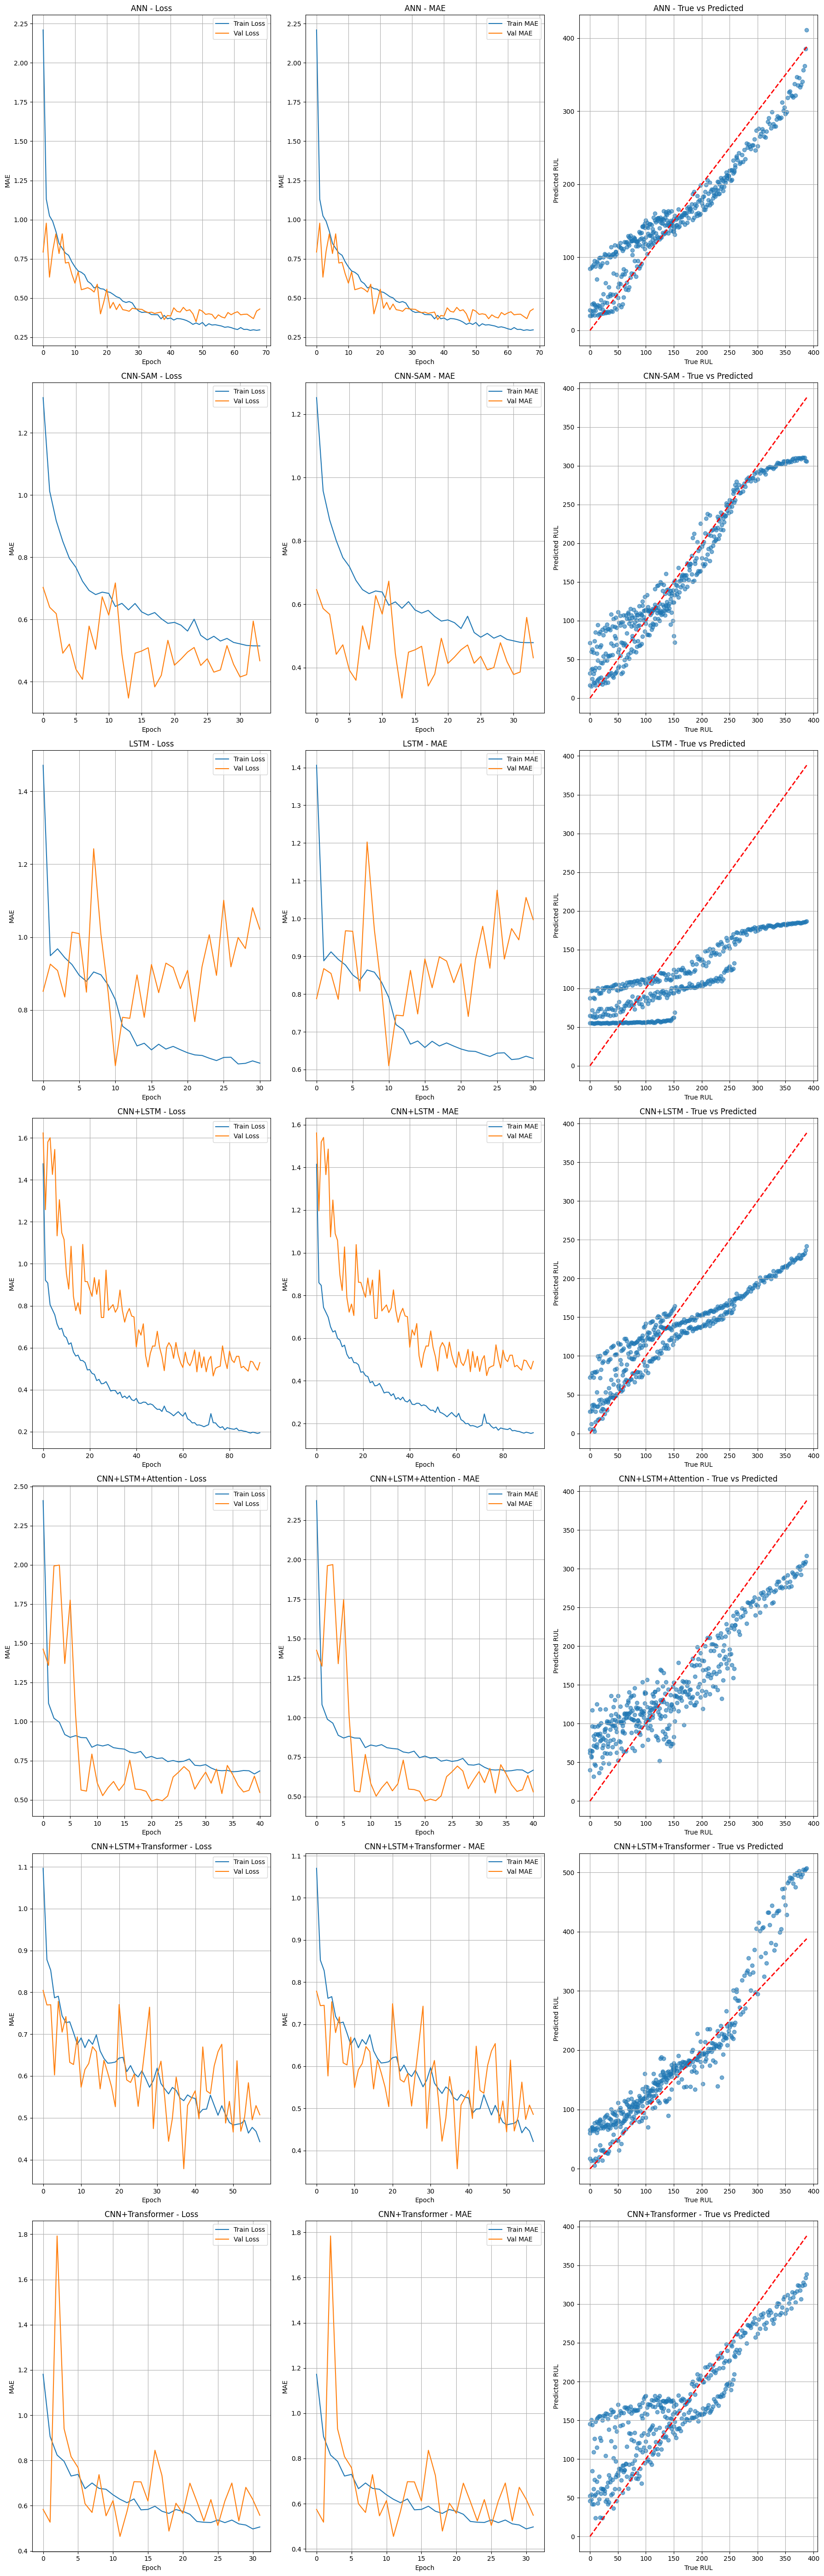

ANN - MSE: 1240.6687, RMSE: 35.2231, MAE: 29.2977, R²: 0.8817
CNN-SAM - MSE: 825.2427, RMSE: 28.7270, MAE: 22.0576, R²: 0.9213
LSTM - MSE: 6623.2412, RMSE: 81.3833, MAE: 66.2143, R²: 0.3684
CNN+LSTM - MSE: 4019.8665, RMSE: 63.4024, MAE: 49.2448, R²: 0.6167
CNN+LSTM+Attention - MSE: 2313.0864, RMSE: 48.0946, MAE: 41.4834, R²: 0.7794
CNN+LSTM+Transformer - MSE: 2101.6990, RMSE: 45.8443, MAE: 33.9888, R²: 0.7996
CNN+Transformer - MSE: 2661.3118, RMSE: 51.5879, MAE: 39.5936, R²: 0.7462


In [33]:
# Plot Training History and True vs Predicted Results for trained models

fig, axes = plt.subplots(len(model_info), 3, figsize=(18, 8*len(model_info)))
if len(model_info) == 1:
    axes = np.array([axes])

for i, (model_name, model) in enumerate(model_info.items()):
    axes[i, 0].plot(model['history'].history['loss'], label='Train Loss')
    axes[i, 0].plot(model['history'].history['val_loss'], label='Val Loss')
    axes[i, 0].set_title(f'{model_name} - Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('MAE')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    axes[i, 1].plot(model['history'].history['mae'], label='Train MAE')
    axes[i, 1].plot(model['history'].history['val_mae'], label='Val MAE')
    axes[i, 1].set_title(f'{model_name} - MAE')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('MAE')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

    axes[i, 2].scatter(model['results'][0], model['results'][1], alpha=0.6)
    ymin, ymax = model['results'][0].min(), model['results'][0].max()
    axes[i, 2].plot([ymin, ymax], [ymin, ymax], 'r--', lw=2)
    axes[i, 2].set_xlabel('True RUL')
    axes[i, 2].set_ylabel('Predicted RUL')
    axes[i, 2].set_title(f'{model_name} - True vs Predicted')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.show()

for model_name, model in model_info.items():
    print(f"{model_name} - MSE: {model['mse']:.4f}, RMSE: {model['rmse']:.4f}, MAE: {model['mae']:.4f}, R²: {model['r2']:.4f}")

25C05 - ANN R²: -0.475


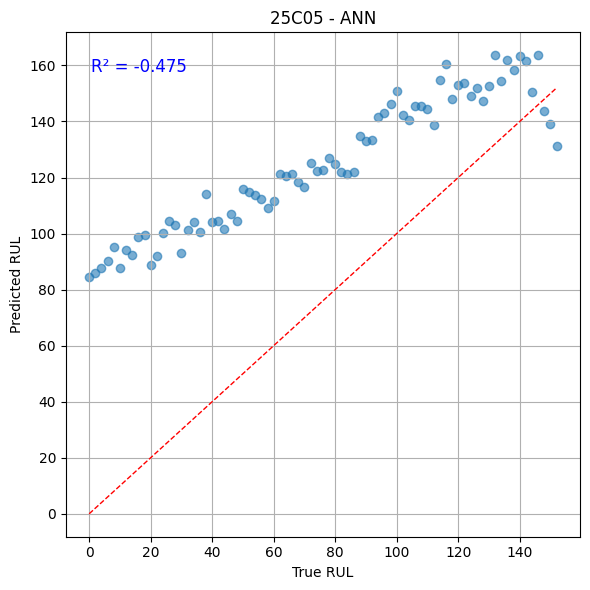

35C02 - ANN R²: 0.905


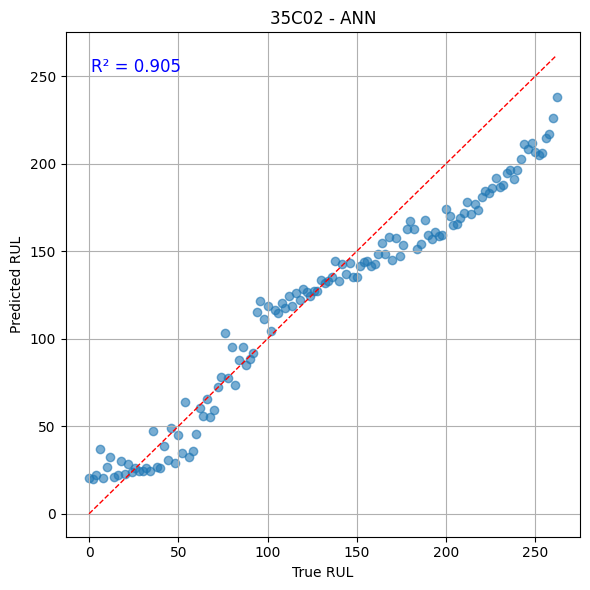

45C02 - ANN R²: 0.918


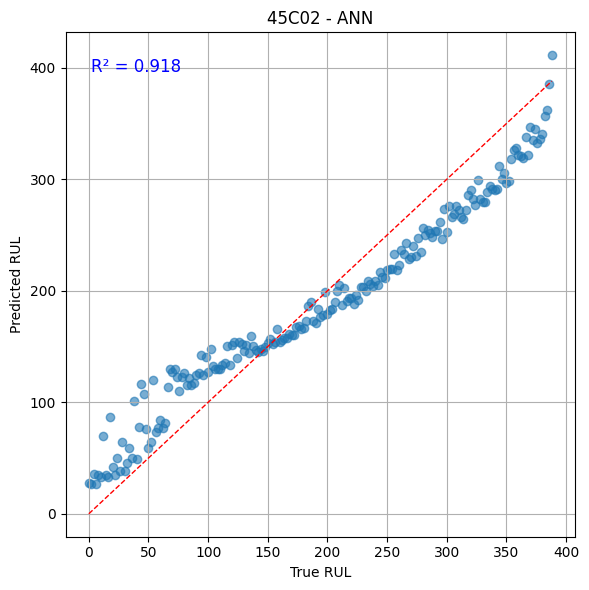

25C05 - CNN-SAM R²: 0.033


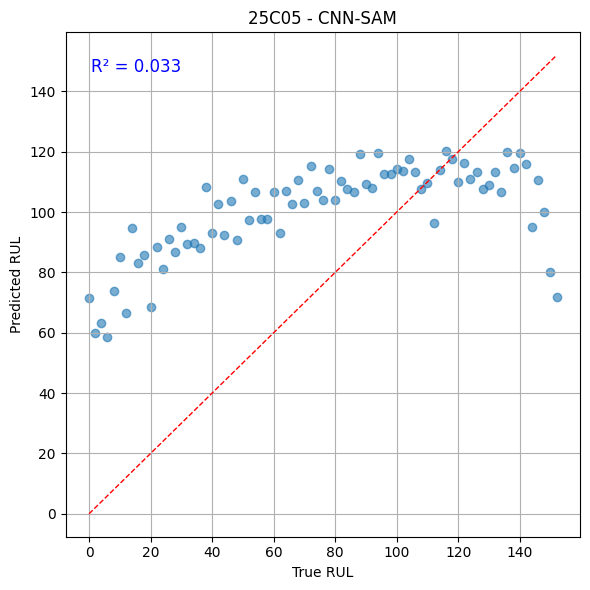

35C02 - CNN-SAM R²: 0.941


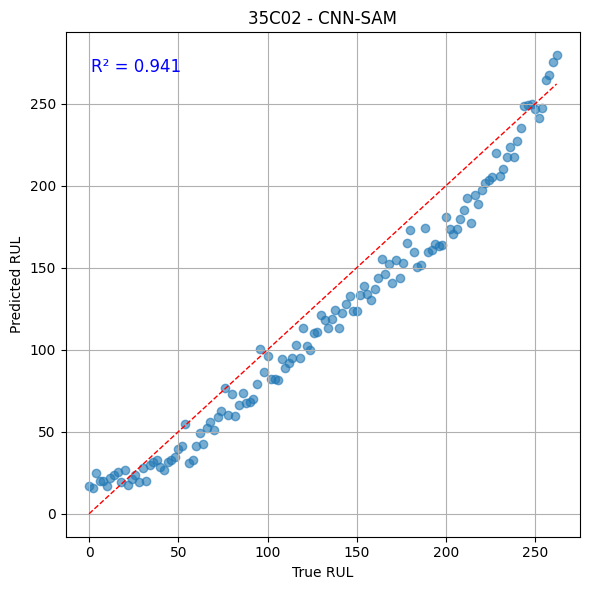

45C02 - CNN-SAM R²: 0.943


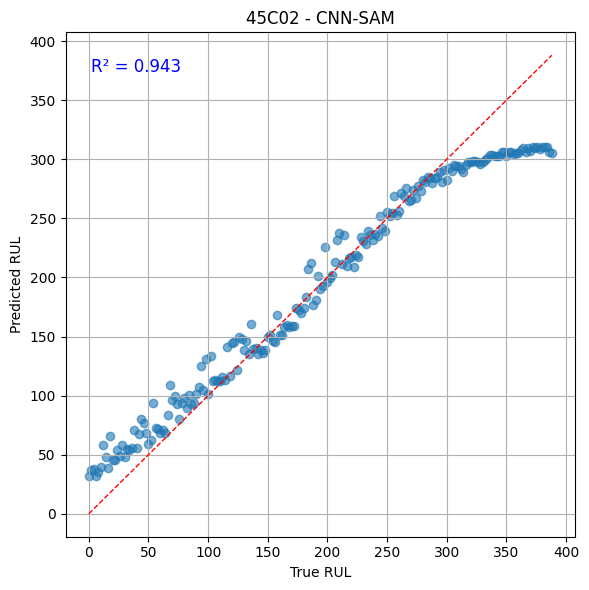

25C05 - LSTM R²: -0.131


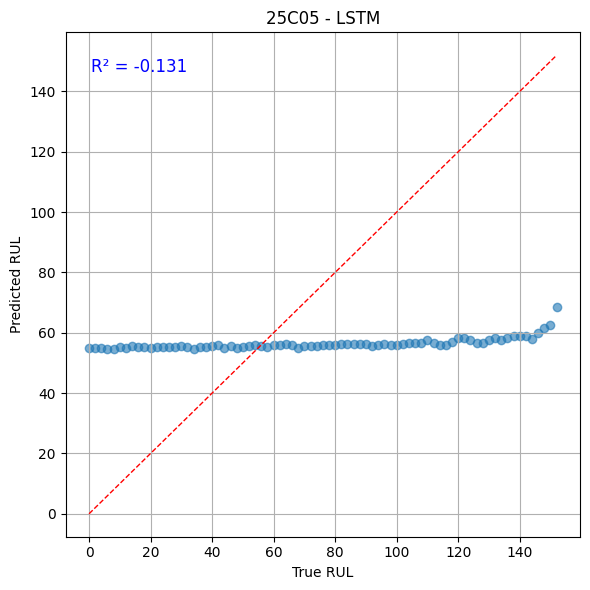

35C02 - LSTM R²: 0.164


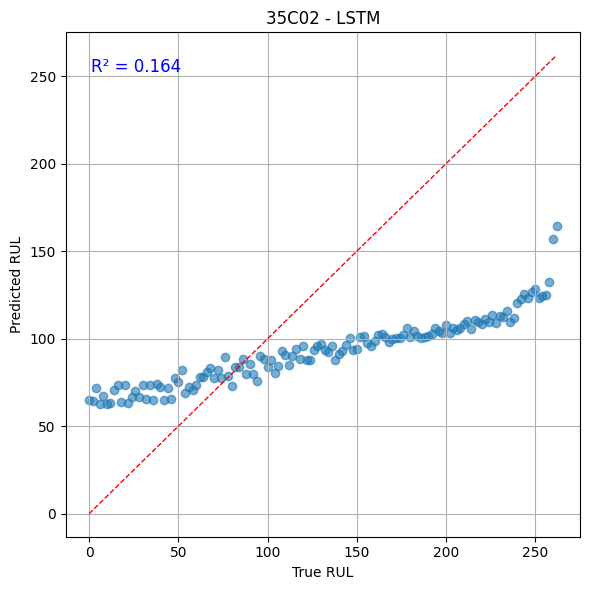

45C02 - LSTM R²: 0.246


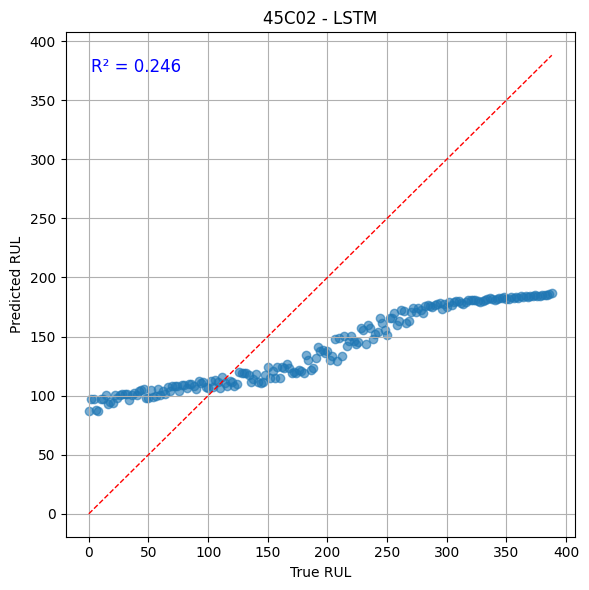

25C05 - CNN+LSTM R²: -0.249


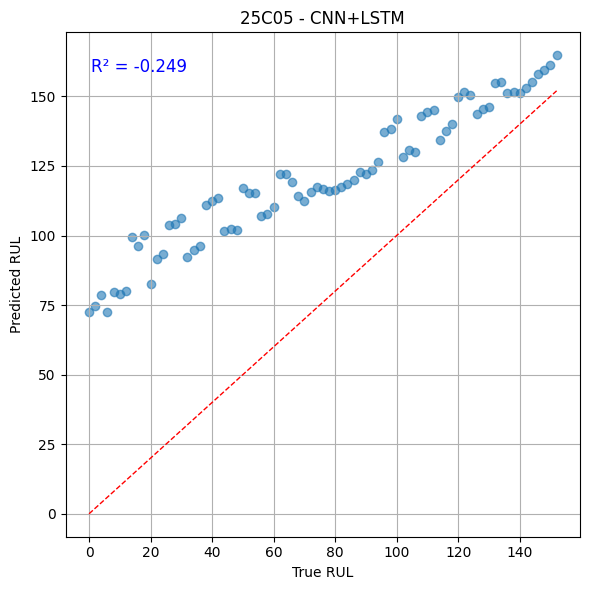

35C02 - CNN+LSTM R²: 0.636


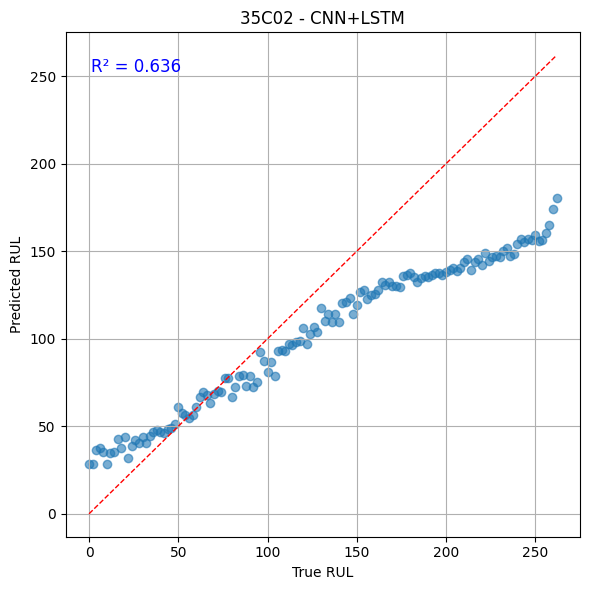

45C02 - CNN+LSTM R²: 0.533


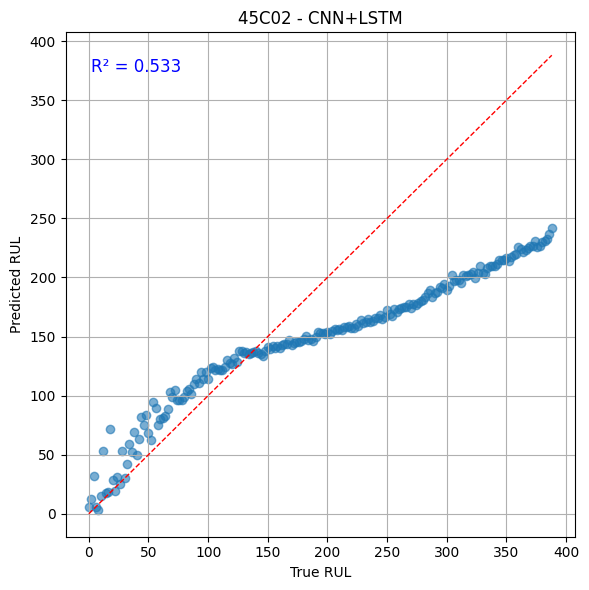

25C05 - CNN+LSTM+Attention R²: -0.314


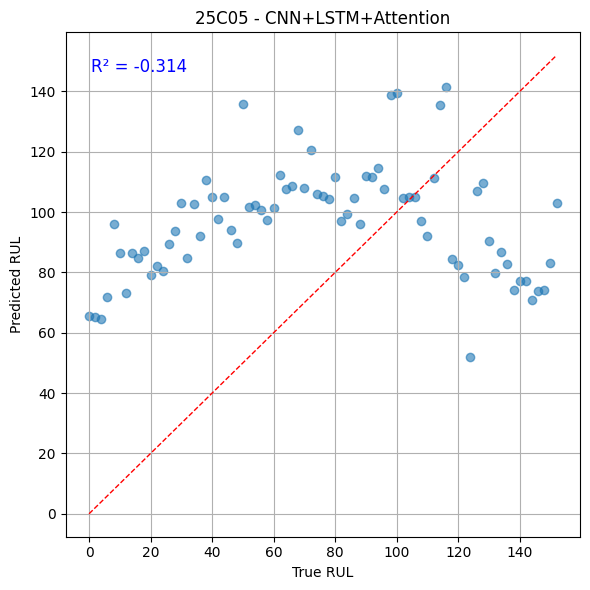

35C02 - CNN+LSTM+Attention R²: 0.562


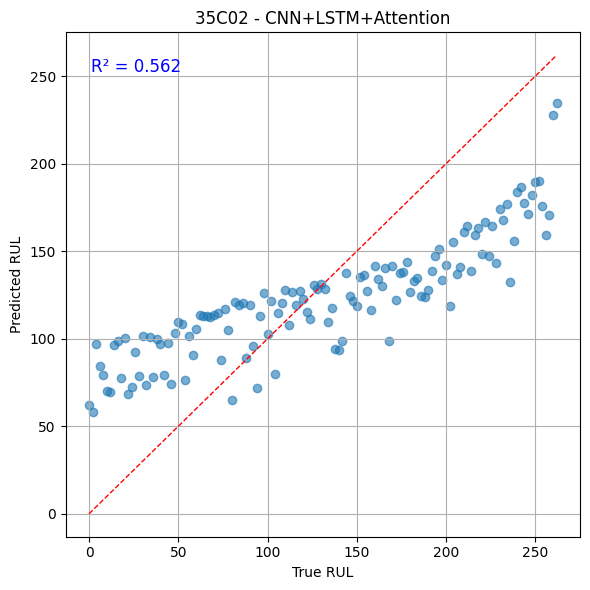

45C02 - CNN+LSTM+Attention R²: 0.839


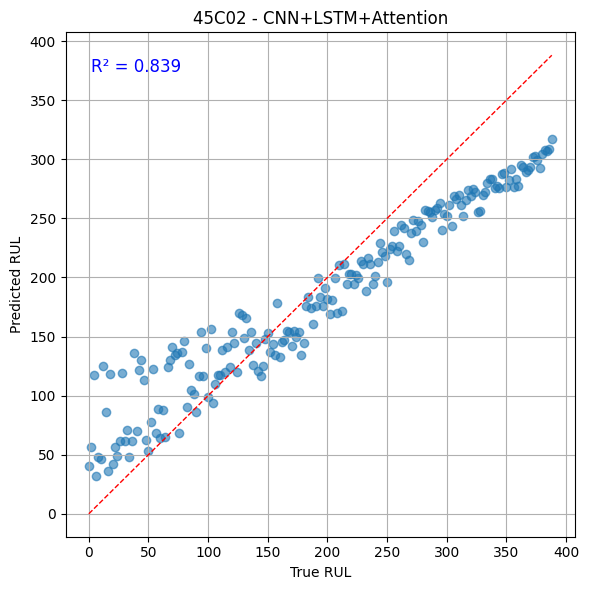

25C05 - CNN+LSTM+Transformer R²: 0.152


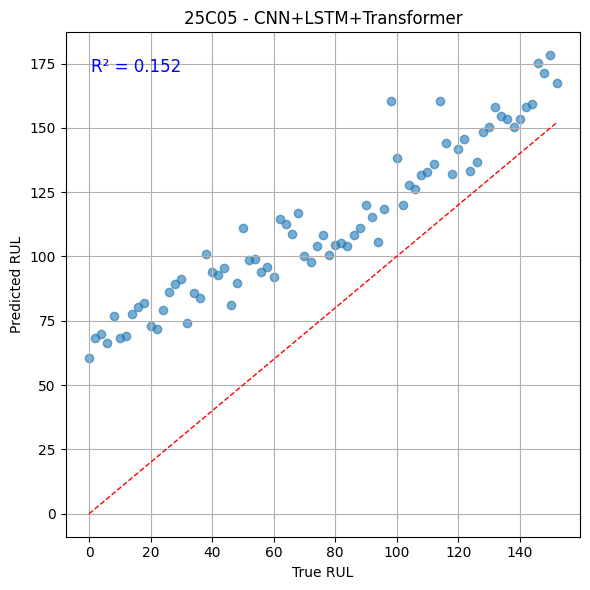

35C02 - CNN+LSTM+Transformer R²: 0.845


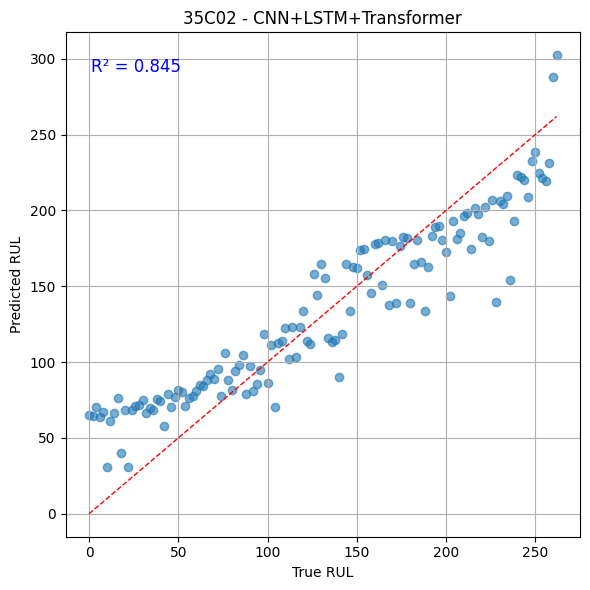

45C02 - CNN+LSTM+Transformer R²: 0.757


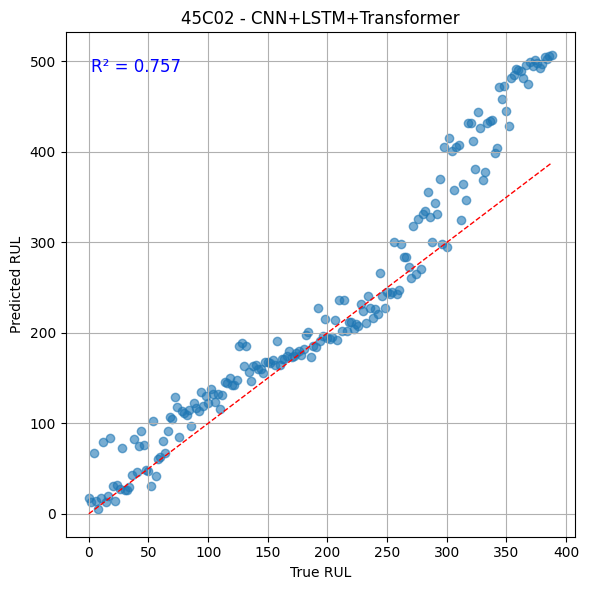

25C05 - CNN+Transformer R²: -3.396


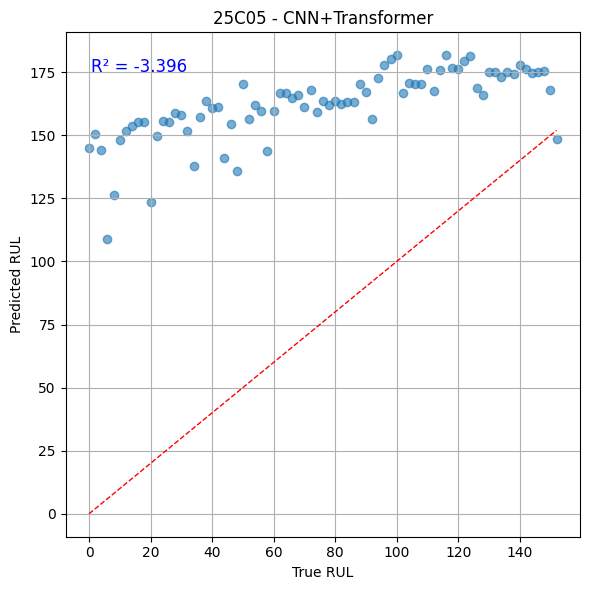

35C02 - CNN+Transformer R²: 0.831


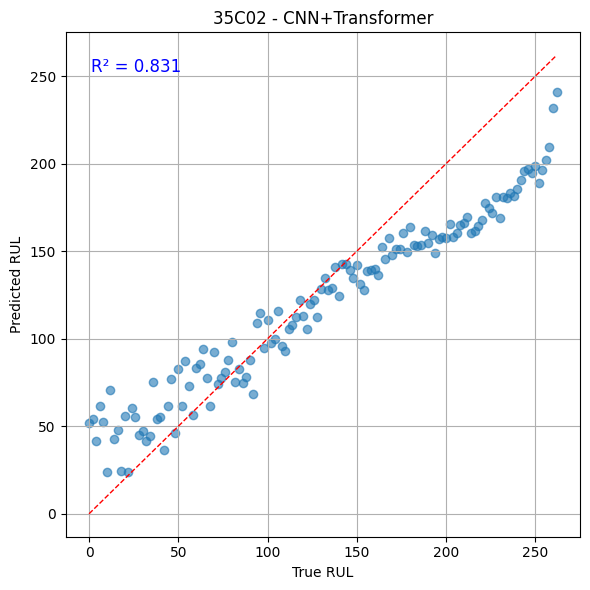

45C02 - CNN+Transformer R²: 0.888


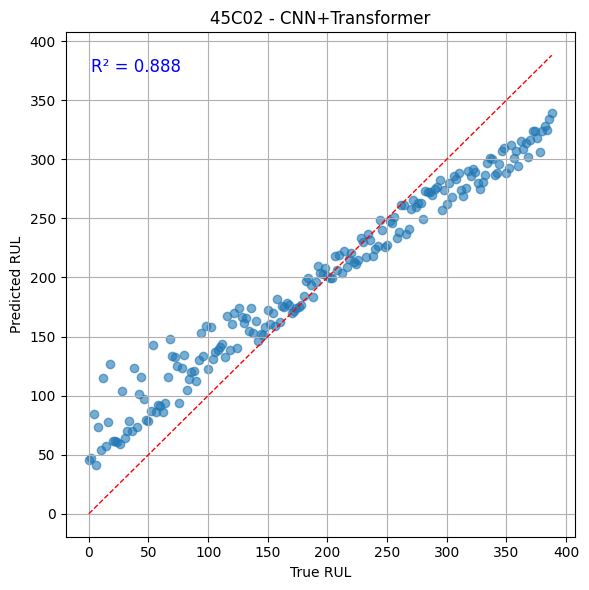

In [35]:
for model_name, model in model_info.items():
    for bat in testing_batteries:
        # Prepare dataset depending on model type
        if model_name == 'ANN':
            X, y = prepare_flatten_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)
        else:
            X, y = prepare_3d_dataset(battery_data, [bat], features=FEATURES, frequencies_max=FREQUENCIES_MAX)

        # Scale + predict
        X = model['scaler'].transform(X)
        y_pred = model['model'].predict(X, verbose=0).flatten()
        y_pred = log_inverse(y_pred)

        # Metrics
        r2 = r2_score(y, y_pred)
        print(f"{bat} - {model_name} R²: {r2:.3f}")

        # Individual plot
        plt.figure(figsize=(6, 6))
        plt.scatter(y, y_pred, alpha=0.6)
        ymin, ymax = y.min(), y.max()
        plt.plot([ymin, ymax], [ymin, ymax], 'r--', lw=1)

        # Add title and R² text
        plt.title(f'{bat} - {model_name}')
        plt.xlabel('True RUL')
        plt.ylabel('Predicted RUL')
        plt.text(0.05, 0.95, f'R² = {r2:.3f}', 
                 transform=plt.gca().transAxes,
                 fontsize=12, color='blue', 
                 verticalalignment='top')

        plt.grid(True)
        plt.tight_layout()
        plt.show()